1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks  
для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).    
2.	И затем обучить Модель на выбор из segmentation_models_pytorch  
3.	*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе   https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И   попробуйте обучить получившуюся нейронную сеть.

In [62]:
import pandas as pd
import numpy as np
import os

import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import time

In [9]:
path = 'set-lipstick-original/list.csv'
df = pd.read_csv(path)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [10]:
# a = 'set-lipstick-original/mask/'
# for i in df.iloc[:,8]:
#     if os.path.join(a, i) == False:
#         df = df.loc[df['mask'] != i]
#         df.to_csv('new_list')

In [11]:
# a = 'set-lipstick-original/720p/'
# for i in df.iloc[:,0]:
#     if os.path.join(a, i) == False:
#         df = df.loc[df['720p'] != i]
#         df.to_csv('new_list')

In [12]:
# df = pd.read_csv('new_list', index_col = 0)
# df.shape

In [13]:
# # set-lipstick-original/mask/mask00010795.png'
# df[df['mask']== 'mask00010769.png']

In [14]:
# df = df[df['mask']!= 'mask00010769.png']

In [15]:
mask_directory = 'set-lipstick-original/mask'
img_directory = 'set-lipstick-original/720p'
mask_files = os.listdir(mask_directory)
img_files = os.listdir(img_directory)
print(len(mask_files))
print(len(img_files))

28540
28593


In [114]:
# len(np.unique(plt.imread('set-lipstick-original/mask/mask00000001.png')[:,:,0]*255))

78

In [16]:
df_n = pd.DataFrame({'img': img_files})

In [17]:
df_n['mask'] =pd.Series(mask_files)

In [18]:
df_n = df_n.dropna()

In [19]:
df_n.isna().sum()

img     0
mask    0
dtype: int64

In [20]:
df_n.shape

(28540, 2)

In [21]:
df_n = df_n.head(200)

In [22]:
df_n.shape

(200, 2)

In [23]:
RANDOM_STATE=43

In [24]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test

In [25]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [26]:
labels = ['lips']

[  0 255]


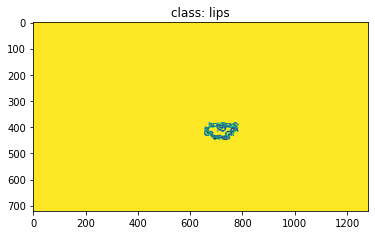

In [27]:
for i in range(1):
    mask = plt.imread('set-lipstick-original/mask/mask00000001.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [28]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info, i_dir, m_dir):
        self.data_info = data_info
        self.i_dir = i_dir
        self.m_dir = m_dir
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        img_path = os.path.join(self.i_dir, self.data_info.iloc[index, 0])
        mask_path = os.path.join(self.m_dir, self.data_info.iloc[index, 1])
        img = np.asarray(Image.open(img_path)).astype('float')
        img = torch.as_tensor(img)/255
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        lab = np.asarray(plt.imread(mask_path)).astype('float')[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_n,test_size=0.2)



X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


train_data = CustomDatasetFromImages(X_train, 'set-lipstick-original/720p/', 'set-lipstick-original/mask/')
test_data = CustomDatasetFromImages(X_test, 'set-lipstick-original/720p/', 'set-lipstick-original/mask/')

In [30]:
train_data_loader = DataLoader(train_data,batch_size=5,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=5,shuffle=False)

In [31]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std())

tensor(0.4774) tensor(0.2069)


In [103]:
# train_dataset = MyOwnCifar(X_train, trans_actions)
# valid_dataset = MyOwnCifar(X_test, transforms.ToTensor())

In [104]:
# trans_actions = transforms.Compose([transforms.Scale(256),
#                                     transforms.RandomCrop(224, padding=0),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                                          std=[0.229, 0.224, 0.225])])
# valid_transforms = transforms.Compose([transforms.ToTensor(),
#                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                                          std=[0.229, 0.224, 0.225])])

In [105]:
# train_data = CustomImageDataset(X_train,
#                              'set-lipstick-original/720p/', 'set-lipstick-original/mask/',trans_actions)
# test_data = CustomImageDataset(X_test,
#                              'set-lipstick-original/720p/', 'set-lipstick-original/mask/',valid_transforms)

In [106]:
# train_data_loader = torch.utils.data.DataLoader(train_data,batch_size=100,shuffle=True)
# test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=100,shuffle=False)

In [107]:
learning_rate = 0.0001
epochs = 1

In [5]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.contracting_11(X) # [-1, 64, 256, 256]
        x2 = self.contracting_12(x1) # [-1, 64, 128, 128]
        x3 = self.contracting_21(x2) # [-1, 128, 128, 128]
        x4 = self.contracting_22(x3) # [-1, 128, 64, 64]
        x5 = self.contracting_31(x4) # [-1, 256, 64, 64]
        x6 = self.contracting_32(x5) # [-1, 256, 32, 32]
        x7 = self.contracting_41(x6) # [-1, 512, 32, 32]
        x8 = self.contracting_42(x7) # [-1, 512, 16, 16]
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        x = self.expansive_12(torch.cat((x, x7), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        x = self.expansive_21(x) # [-1, 256, 64, 64]
        x = self.expansive_22(torch.cat((x, x5), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        x = self.expansive_31(x) # [-1, 128, 128, 128]
#         print(x.shape, x3.shape)
#         x = self.expansive_32(torch.cat((x, x3), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        x = self.expansive_41(x) # [-1, 64, 256, 256]
#         x = self.expansive_42(torch.cat((x, x1), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [68]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
#     print(output)
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(3, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [110]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [111]:
device

device(type='cpu')

In [112]:
model = UNet(1)

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

NameError: name 'model' is not defined

In [114]:
# The training loop
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 32 total_steps per epoch


In [115]:
step_losses = []
epoch_losses = []

In [116]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         inputs = inputs.cuda()
#         labels = labels.cuda()
  
        # zero the parameter gradients
        optimizer.zero_grad()
      
      
        outputs = model(inputs[0])
  
        loss = dice_loss(outputs,labels[0,0,:,:,:])
#         loss = criterion(outputs, labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')

Epoch 1, loss:  -0.47671178355813026  time = 162.27005410194397 sec


In [3]:
PATH = './selflipsmodel.pth'

In [2]:

torch.save(model.state_dict(), PATH)

NameError: name 'model' is not defined

In [7]:
# net=UNet(1)
net=UNet(1)

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

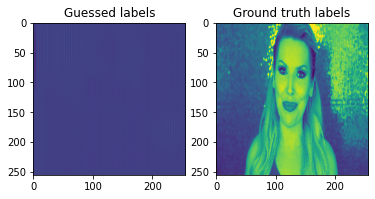

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


<Figure size 432x288 with 0 Axes>

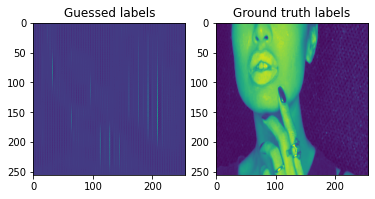

<Figure size 432x288 with 0 Axes>

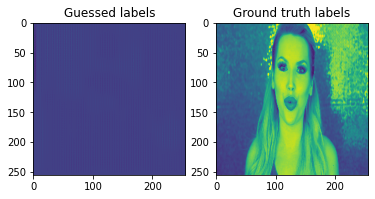

<Figure size 432x288 with 0 Axes>

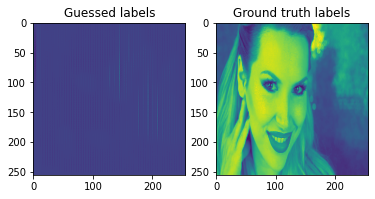

<Figure size 432x288 with 0 Axes>

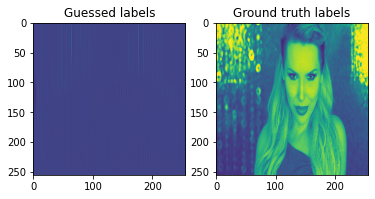

<Figure size 432x288 with 0 Axes>

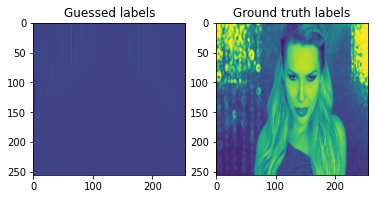

<Figure size 432x288 with 0 Axes>

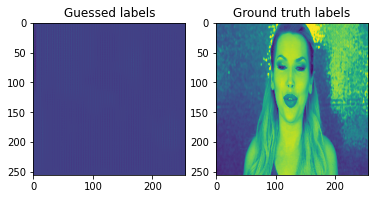

<Figure size 432x288 with 0 Axes>

In [55]:
NET=UNet(1)
NET.load_state_dict(torch.load('./selflipsmodel.pth'))
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = NET(images[0])
    f, axarr = plt.subplots(1,2)
#     axarr[0]. imshow(torch.argmax(outputs.squeeze(1), dim=2).detach().numpy())
    axarr[0]. imshow(outputs.squeeze().detach().numpy())
    axarr[0].set_title('Guessed labels')

    axarr[1].imshow(images[0].detach().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

In [59]:
import segmentation_models_pytorch as smp

In [106]:

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=78, activation='softmax')
optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.01)

step_losses = []
epoch_losses = []

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         inputs = inputs.cuda()
#         labels = labels.cuda()
        inputs = inputs
        labels = labels


        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = dice_loss(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    

Epoch 1, loss:  0.9996527153998613  time = 30.17935872077942 sec
Epoch 2, loss:  0.999595994129777  time = 28.805532455444336 sec
Epoch 3, loss:  0.9996040053665638  time = 28.78541874885559 sec
Epoch 4, loss:  0.999586271122098  time = 28.83899211883545 sec
Epoch 5, loss:  0.9995813742280006  time = 28.928898572921753 sec


In [98]:
PATH = './selflipsmodel2.pth'

In [99]:
torch.save(segmodel.state_dict(), PATH)

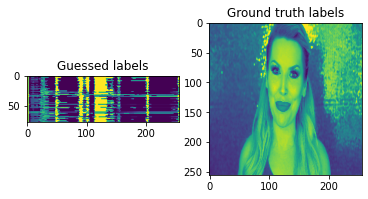

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


<Figure size 432x288 with 0 Axes>

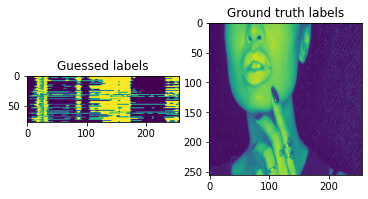

<Figure size 432x288 with 0 Axes>

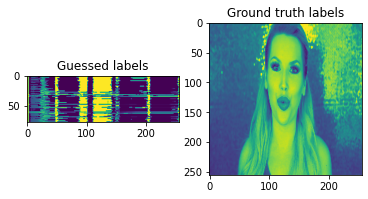

<Figure size 432x288 with 0 Axes>

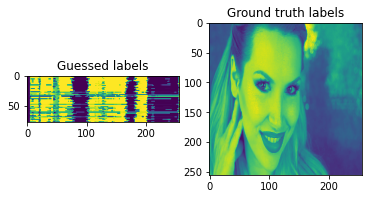

<Figure size 432x288 with 0 Axes>

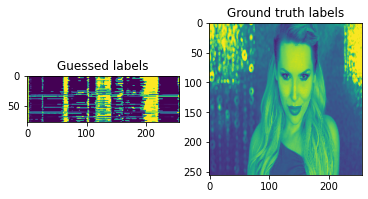

<Figure size 432x288 with 0 Axes>

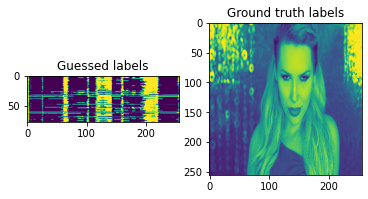

<Figure size 432x288 with 0 Axes>

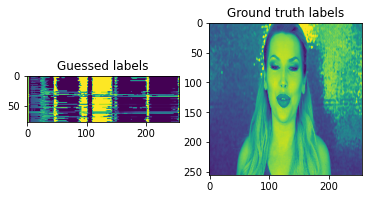

<Figure size 432x288 with 0 Axes>

In [110]:
NET=segmodel
# NET.load_state_dict(torch.load('./selflipsmodel.pth'))
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = NET(images[0])
    f, axarr = plt.subplots(1,2)
    axarr[0]. imshow(torch.argmax(outputs.squeeze(), dim=1).detach().numpy())
#     axarr[0]. imshow(outputs.squeeze().detach().numpy())
    axarr[0].set_title('Guessed labels')

    axarr[1].imshow(images[0].detach().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    plt.show()
    plt.gcf().show()
    if i>5:
        break